# Sort spikes and make rasters

For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'
N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

if 'pakhi' in socket.gethostname():
    os.environ["KILOSORT3_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'
if 'pouli' in socket.gethostname():
    os.environ["KILOSORT3_PATH"] = '/home/pouli/repos/Kilosort'

2022-04-20 18:15:16,408 root         INFO     Running on pakhi


In [2]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2022-04-20 18:15:17,258 root         INFO     all modules loaded


### Session parameters and raw files

In [3]:
reload(et)

bird = 'z_r12r13_21'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [4]:
reload(et)

sess_par = {'bird': 'z_r12r13_21',
           'sess': '2021-06-28',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 1, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': '2021-06-27'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [5]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx'

In [6]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2022-04-20 18:15:28,287 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21', 'raw': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28', 'sglx': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx', 'kwik': '/scratch/earneodo/z_r12r13_21/sglx/kwik/2021-06-28', 'processed': '/mnt/sphere/speech_bci/processed_data/z_r12r13_21/2021-06-28/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/z_r12r13_21/sglx/msort/2021-06-28', 'ksort': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/rig.json', 'kwd'

['0153_g0', '023_g0', '0701_g0', '1006_g0', '1201_g0', '1459_g0', '1806_g0']

In [27]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[2] # g2 is the shortest
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [28]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/0701_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/0701_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/0701_g0',
  'kwik': '/scratch/earneodo/z_r12r13_21/sglx/kwik/2021-06-28/0701_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/z_r12r13_21/2021-06-28/sglx/0701_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0',
  'tmp': '/scratch/earneodo/tmp/0701_g0',
  'msort': '/scratch/earneodo/z_r12r13_21/sglx/msort/2021-06-28/0701_g0',
  'ksort': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/0701_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/sort_0'},
 'files': {'par': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/0701_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/z_r12r

In [29]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/0701_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/0701_g0/0701_g0_imec0'}

In [30]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/0701_g0/0701_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/0701_g0/0701_g0_imec0/0701_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/0701_g0/0701_g0_imec0/0701_g0_t0.imec0.ap.meta']}

### load epoch files

In [31]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
#probe_data_folder = sgl_folder['imec'][probe_id]


In [32]:
run_recordings

{'nidq': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f399c9aab20>,
 'lf_0': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f399ce9e850>,
 'ap_0': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f399c9aad30>}

### Sync signals
(starts in a process, will let know when done. The idea is that it can run while spike sorting, if its long)

In [115]:
# all the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) + ['wav']

#all_streams = ['lf_0', 'ap_0', 'nidq']
#all_streams = ['ap_0', 'wav']
all_syn_dict = {k: sy.get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

sort_p = Process(target=sy.sync_all, args=(all_syn_dict, sess_par['ref_stream']), 
                 kwargs={'force': False}
                )
sort_p.start()

2022-04-21 12:02:32,610 ceciestunepipe.util.sglxsync INFO     getting syn patterns for nidq
2022-04-21 12:02:32,989 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/nidq_sync_dict.pkl
2022-04-21 12:02:41,339 ceciestunepipe.util.sglxsync INFO     getting syn patterns for lf_0
2022-04-21 12:02:41,414 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/lf_0_sync_dict.pkl
2022-04-21 12:02:42,836 ceciestunepipe.util.sglxsync INFO     getting syn patterns for ap_0
2022-04-21 12:02:42,880 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/ap_0_sync_dict.pkl
2022-04-21 12:02:43,004 ceciestunepipe.util.sglxsync INFO     getting syn patterns for wav
2022-04-21 12:02:43,017 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/d

## Debug the sync.

read the ttls and count the onsets/offsets.
look at the nidq/ap0 actual channels and see where the difference comes from.

In [35]:
all_syn_dict['nidq']

{'path': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/nidq_sync_dict.pkl',
 's_f': 24999.661084681255,
 't_0_path': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/nidq_t0.npy',
 'evt_arr_path': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/nidq_sync_evt.npy',
 'evt_arr': memmap([[      742,     13105,     25742, ..., 262734542, 262747181,
          262759542],
         [        1,        -1,         1, ...,        -1,         1,
                 -1]]),
 't_0': memmap([0.00000000e+00, 4.00005423e-05, 8.00010845e-05, ...,
         1.05108225e+04, 1.05108225e+04, 1.05108225e+04])}

##### nidq events and times


In [54]:
nidq_evt = all_syn_dict['nidq']['evt_arr']
nidq_evt_t = all_syn_dict['nidq']['t_0'][nidq_evt[0]]
nidq_evt.shape

(2, 21022)

In [151]:
### seee that no beat was skipped
periods = np.unique(np.round((np.unique(np.diff(nidq_evt_t))*1000)/50)*50).astype(int)

In [158]:
edges = np.unique(np.diff(nidq_evt[1][::2]))
edges

array([0])

In [165]:
np.all(np.unique(np.hstack([np.diff(nidq_evt[1][1:][::2]), np.diff(nidq_evt[1][::2])]))==0)

True

In [59]:
np.unique(np.diff(nidq_evt[1]))

array([-2,  2])

In [61]:
# what was the last edge
nidq_evt[:,-1]

memmap([262759542,        -1])

In [63]:
nidq_evt_t[-1]

10510.52416710593

###### ap_0 events and times

In [60]:
ap_evt = all_syn_dict['ap_0']['evt_arr']
ap_evt_t = all_syn_dict['ap_0']['t_0'][ap_evt[0]]
ap_evt.shape

(2, 21021)

In [64]:
np.unique(np.diff(ap_evt_t))

array([0.49993373, 0.49993373, 0.49993373, 0.49993373, 0.49993373,
       0.49993373, 0.49996707, 0.49996707, 0.49996707, 0.49996707,
       0.49996707, 0.49996707, 0.49996707, 0.49996707, 0.49996707,
       0.49996707, 0.49996707, 0.49996707, 0.49996707, 0.49996707,
       0.49996707, 0.5000004 , 0.5000004 , 0.5000004 , 0.5000004 ,
       0.5000004 , 0.5000004 , 0.5000004 , 0.5000004 , 0.50003373,
       0.50003373, 0.50003373, 0.50003373, 0.50003373, 0.50003373,
       0.50003373, 0.50003373, 0.50003373, 0.50003373, 0.50003373,
       0.50003373, 0.50003373, 0.50003373])

In [41]:
np.unique(np.diff(ap_evt[1]))

array([-2,  2])

In [49]:
ap_evt[:,-1]

memmap([315300640,         1])

In [65]:
ap_evt_t[-1]

10510.029733756737

###### in this case it seems the nidq caught one last ttl edge (-1) that the ap did not. 
Will try to ignore that one and sync

In [81]:
last_edge

21021

In [97]:
all_syn_dict = sy.ignore_last_edge(all_syn_dict, 'ap_0')
all_syn_dict = sy.sync_all(all_syn_dict, 'ap_0', force=False)

2022-04-21 11:51:18,371 ceciestunepipe.util.sglxsync INFO     syncing all times to ap_0
2022-04-21 11:51:18,372 ceciestunepipe.util.sglxsync INFO      synch nidq...
2022-04-21 11:51:18,375 ceciestunepipe.util.sglxsync INFO       t_prime file /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/nidq-tp.npy not found or forced computation, getting the events
2022-04-21 11:51:34,208 ceciestunepipe.util.sglxsync INFO         saving t_prime array to /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/nidq-tp.npy
2022-04-21 11:51:37,379 ceciestunepipe.util.sglxsync INFO         saving synced dict to /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/nidq_sync_dict.pkl
2022-04-21 11:51:41,696 ceciestunepipe.util.sglxsync INFO      synch lf_0...
2022-04-21 11:51:41,701 ceciestunepipe.util.sglxsync INFO       t_prime file /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/lf_0-tp.npy not found or forced computation

## The sorting

- invoke the recording extractor where the probe is
- quickly check data (chans look ok?)
- set parameters
- use the recording extractor and the function to sort with kilosort
- ALTERNATIVELY: do the manual curation
- Load the spikes using the functions from ceciestunepipe

##### pick one ap stream, view it after running some of the toolkits

In [101]:
ap_extractor = run_recordings['ap_0']

###### view it raw

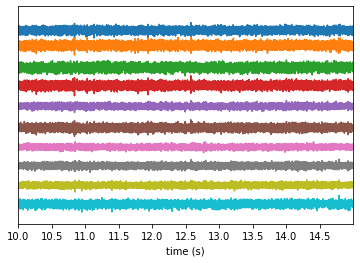

In [102]:
sw.plot_timeseries(ap_extractor, channel_ids=range(40, 50), trange=[10,15])

###### filtered

In [103]:
# ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
# sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[10,15])

###### cmr

In [104]:
# ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
# sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(45, 55), trange=[10,15])

In [105]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/0701_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/0701_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/0701_g0',
 'kwik': '/scratch/earneodo/z_r12r13_21/sglx/kwik/2021-06-28/0701_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/z_r12r13_21/2021-06-28/sglx/0701_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0',
 'tmp': '/scratch/earneodo/tmp/0701_g0',
 'msort': '/scratch/earneodo/z_r12r13_21/sglx/msort/2021-06-28/0701_g0',
 'ksort': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/0701_g0/sort_0',
 'sort': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/sort_0'}

In [106]:
ss.__version__

'0.4.5'

In [107]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [108]:
default_ks3_params = ss.Kilosort3Sorter.default_params()
default_ks3_params

{'detect_threshold': 6,
 'projection_threshold': [9, 9],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 300,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500}

##### manually enter ksort params

In [109]:
ks_params = {'minFR': 0.001,
             'minfr_goodchannels': 0.001}

In [110]:
tmp_loc = exp_struct['folders']['ksort']
tmp_loc

'/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/0701_g0/sort_0'

#### run the spike sort

In [111]:
reload(ks)

<module 'ceciestunepipe.util.spike.kilosort' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py'>

In [112]:
## 
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle')
def do_sort():
    return ks.run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, 
                     sorting_method='kilosort3', chunk_mb=8192, force_redo=False,
                     **ks_params)

sort_p = Process(target=do_sort)
sort_p.start()

2022-04-21 12:00:23,740 root         INFO     Grouping property: None
2022-04-21 12:00:23,744 root         INFO     sorting method: kilosort3
2022-04-21 12:00:23,745 root         INFO     Will set visible gpu devices 1
2022-04-21 12:00:23,747 root         INFO     Previous sort not found, sorting
2022-04-21 12:00:23,746 root         INFO     Sorting tmp dir /scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/0701_g0/sort_0/tmp_ks3
Writing to binary .dat file: 100%|##########| 30/30 [11:36<00:00, 23.22s/it]


kilosort3 run time 7206.04s


Process Process-7:
Traceback (most recent call last):
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-112-7347fc6a8a01>", line 4, in do_sort
    return ks.run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1,
  File "/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py", line 170, in run_spikesort
    sort = ss.run_kilosort3(
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/spikesorters/sorterlist.py", line 527, in run_kilosort3
    return run_sorter('kilosort3', *args, **kwargs)
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/spikesorters/sorterlist.py", line 94, in run_sorter
    sortingextractor = sorter.get_result(raise_error=rai

### interlude: process and sync the motifs

###### load the motif dict

In [128]:
### load the sync. It should come computed from above, in the process that ran in the background
sy.sync_all(all_syn_dict, sess_par['ref_stream'], force=False)

2022-04-21 12:13:56,704 ceciestunepipe.util.sglxsync INFO     syncing all times to ap_0
2022-04-21 12:13:56,705 ceciestunepipe.util.sglxsync INFO      synch nidq...
2022-04-21 12:13:56,891 ceciestunepipe.util.sglxsync INFO      synch lf_0...
2022-04-21 12:13:56,909 ceciestunepipe.util.sglxsync INFO      synch wav...
2022-04-21 12:13:56,920 ceciestunepipe.util.sglxsync INFO     Done with sync_all


In [129]:
match_mot_arr = np.load(os.path.join(os.path.join(exp_struct['folders']['derived'], 'mot_wav_mic.npy')))

bout_dict = sy.bout_dict_from_array(match_mot_arr, all_syn_dict)

In [130]:
bout_dict

{'s_f': 25000,
 's_f_nidq': 24999.661084681255,
 's_f_ap_0': 29999.976021694656,
 'start_ms': array([2414843, 2415549, 2416264, 2418334, 2419051, 2423453, 2424162,
        2424874, 2425600, 2426324, 6424445, 6425140, 6425851, 6426570,
        6429790, 6430501, 6431222, 6431949, 6441742, 6442465, 6443189,
        6549865, 6550583, 6551879, 6553325, 6557182, 6557903, 6559949,
        6560660, 6563902, 6564628, 7108801, 7109514, 7110229, 7113844,
        7114556, 7762157, 7762873, 7763591, 7767685, 7768397, 7769124,
        7769847, 9364848, 9365561, 9366283, 9367002]),
 'len_ms': array([690, 690, 690, 690, 690, 690, 689, 689, 690, 690, 690, 689, 689,
        690, 690, 689, 690, 689, 689, 689, 689, 690, 689, 690, 690, 690,
        689, 689, 690, 690, 690, 689, 689, 689, 690, 689, 689, 689, 689,
        689, 690, 690, 690, 690, 690, 690, 690]),
 'start_sample_naive': array([ 60371075,  60388725,  60406600,  60458350,  60476275,  60586325,
         60604050,  60621850,  60640000,  60658100,

In [131]:
bout_pd = pd.DataFrame.from_dict(bout_dict)
bout_pd.head()

,s_f,s_f_nidq,s_f_ap_0,start_ms,len_ms,start_sample_naive,start_sample_nidq,start_sample_wav,start_ms_ap_0,start_sample_ap_0
0,25000,24999.661085,29999.976022,2414843,690,60371075,60370257,60371076,2.414878e+06,72446272
1,25000,24999.661085,29999.976022,2415549,690,60388725,60387907,60388726,2.415587e+06,72467550
2,25000,24999.661085,29999.976022,2416264,690,60406600,60405782,60406601,2.416300e+06,72488942
3,25000,24999.661085,29999.976022,2418334,690,60458350,60457531,60458351,2.418371e+06,72551067
4,25000,24999.661085,29999.976022,2419051,690,60476275,60475456,60476276,2.419085e+06,72572482


### Save the bout/mot/trial data

In [134]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict_ap0.pkl')
bout_pd_path = os.path.join(exp_struct['folders']['derived'], 'mot_pd_ap0.pkl')

with open(bout_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)
    
bout_pd.to_pickle(bout_pd_path)

logger.info('saved syncronized bout dict and pandas dataframe to {}, {}'.format(bout_dict_path, bout_pd_path))

2022-04-21 12:20:58,090 root         INFO     saved syncronized bout dict and pandas dataframe to /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/mot_dict_ap0.pkl, /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/mot_pd_ap0.pkl


#### load the sort

In [166]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))
spk_df.head(1)

,times,clusters,cluster_id
0,134,409,409


In [167]:
clu_df.head(1)

,cluster_id,KSLabel,group,MSLabel,has_template,template,max_chans,main_chan,main_7,main_wav_7
1,1,good,good,None,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 2, 6, 0, 9, 3, 13, 4, 15, 12, 11, 10, 7, 5...",1,"[0, 1, 2, 3, 6, 9, 13]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."


In [168]:
# count the good ones
np.unique(clu_df[clu_df['KSLabel']=='good']['cluster_id']).size

328

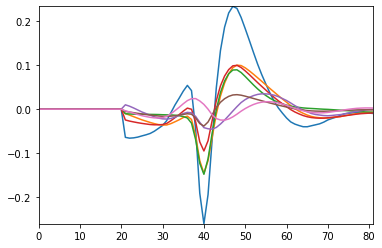

In [169]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

### Visualize a bout together with the neural traces

In [170]:
plt.rcParams['lines.linewidth'] = 0.1

In [171]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [172]:
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

In [173]:
ap_sf = all_syn_dict['ap_0']['s_f']

### one example of bout onset

In [190]:
## call the HVC/RA sites
hvc_chans = list(range(260, 297)) #HVC
ra_chans = list(range(20, 95)) #RA
neur_chans =  ra_chans 

clu_df['nucleus'] = np.nan
clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

In [191]:
mot_idx = 0

mot_start_wav = bout_dict['start_sample_wav'][mot_idx]
mot_start_ap = bout_dict['start_sample_ap_0'][mot_idx]

pre_sec = -2.25
post_sec = 2 - pre_sec

ap_sf = all_syn_dict['ap_0']['s_f']

mic_arr = mic_stream[mot_start_wav + int(pre_sec*s_f_wav): mot_start_wav + int(post_sec*s_f_wav)]

ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

<ipython-input-192-12a952a9720b>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


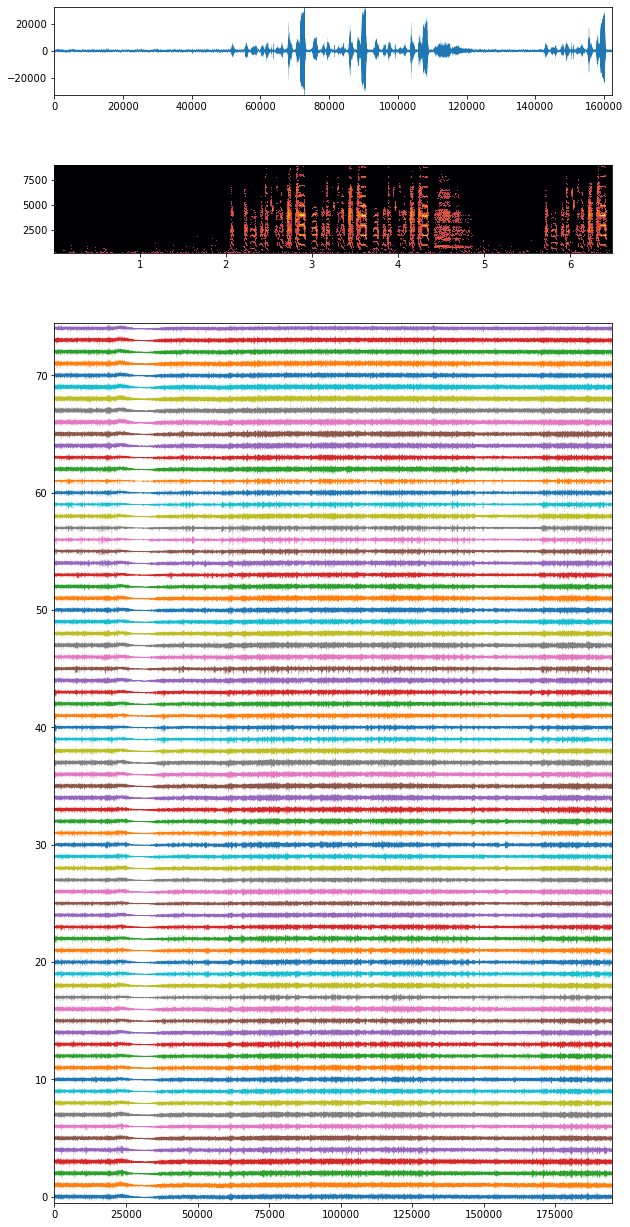

In [192]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

In [194]:
## get the actural raster for some clusters
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

t_pre = - 2
t_post = 2

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = mot_idx
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)
    

spk_arr = ks.get_window_spikes(spk_df, clu_list, start_ap , end_ap)


#rast_arr = ks.get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:99: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [366]:
clu_list.size

54

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


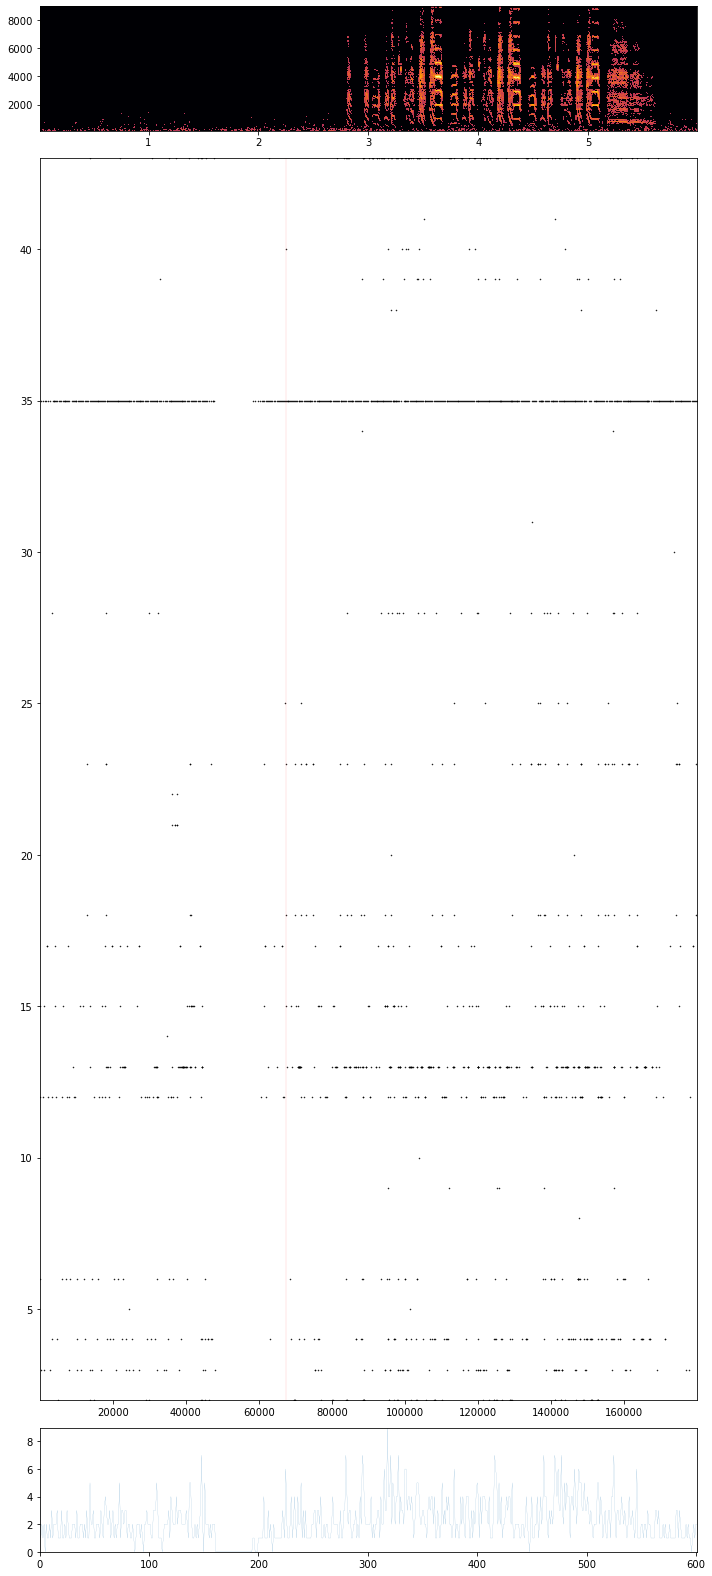

In [196]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 3
t_post = 3

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = mot_idx
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = ks.get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [161]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### save cluster and cluster metadata

In [197]:
clu_df['nucleus'] = np.nan
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'
clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'

sort_folder = os.path.join(exp_struct['folders']['derived'], sess_par['sort'])
os.makedirs(sort_folder, mode=0o777, exist_ok=True)

clu_df_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pickle')
spk_df.to_pickle(spk_df_path)

### plot motif rasters

In [198]:
bout_pd.head()

,s_f,s_f_nidq,s_f_ap_0,start_ms,len_ms,start_sample_naive,start_sample_nidq,start_sample_wav,start_ms_ap_0,start_sample_ap_0
0,25000,24999.661085,29999.976022,2414843,690,60371075,60370257,60371076,2.414878e+06,72446272
1,25000,24999.661085,29999.976022,2415549,690,60388725,60387907,60388726,2.415587e+06,72467550
2,25000,24999.661085,29999.976022,2416264,690,60406600,60405782,60406601,2.416300e+06,72488942
3,25000,24999.661085,29999.976022,2418334,690,60458350,60457531,60458351,2.418371e+06,72551067
4,25000,24999.661085,29999.976022,2419051,690,60476275,60475456,60476276,2.419085e+06,72572482


In [201]:
start_sample_ap_arr = bout_pd['start_sample_ap_0'].values

clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra', 'hvc'])), 
                                'cluster_id'])

In [207]:
start_sample_ap_arr.shape

(47,)

In [203]:
clu_list.size

43

In [204]:
rast_arr = ks.get_rasters(spk_df, clu_list, start_sample_ap_arr + t_pre_samp, t_post_samp - t_pre_samp)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:99: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


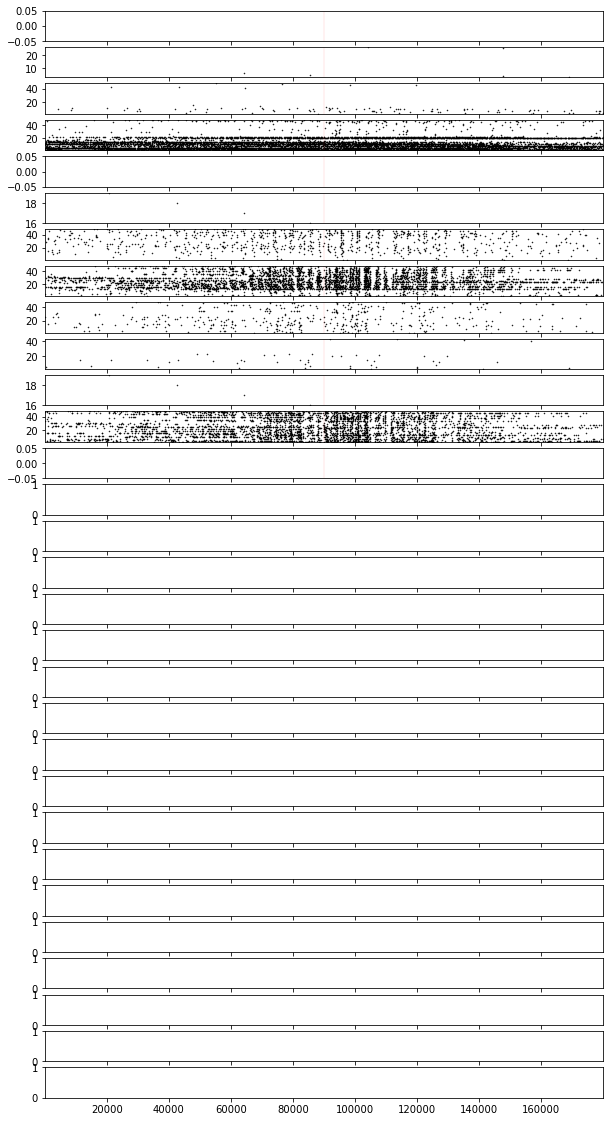

In [208]:
fig, ax_arr = plt.subplots(nrows=30, figsize=[10, 20], sharex=True)

for i_rast, clu_idx in enumerate(range(30,43)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    pu.plot_as_raster(rast_arr[clu_idx].T, t_0=-t_pre_samp, ax=ax_arr[i_rast])

### Now done this, this notebooks has generated:

- Spike sorted data:
    (with quality of sort (be auto or manually in 'MSlabel/KSlabel'))
    clu_df.pickle and spk_df.pickle in 
    /mnt/sphere/speech_bci/derived_data/bird/sess/sglx/epoch/sort_id
    
- Stimulus data:
    stim_pd_ap0.pkl and stim_dict_ap0.pkl
    /mnt/sphere/speech_bci/derived_data/bird/sess/sglx/epoch/
    
    

In [402]:
from IPython.display import Markdown as md

In [210]:
logger.info('The spike sorted data was saved to {}'.format(sort_folder))

2022-04-21 15:50:05,048 root         INFO     The spike sorted data was saved to /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/sort_0


In [212]:
logger.info('The mot/bout data was saved to {}'.format(bout_pd_path))

2022-04-21 15:50:25,183 root         INFO     The mot/bout data was saved to /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0701_g0/mot_pd_ap0.pkl
